### Clustering experimentation

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 333.52it/s]


Files already downloaded and verified
Balanced subset: 1000 images, embeddings shape (1000, 768)
Automatically detected optimal K: 8


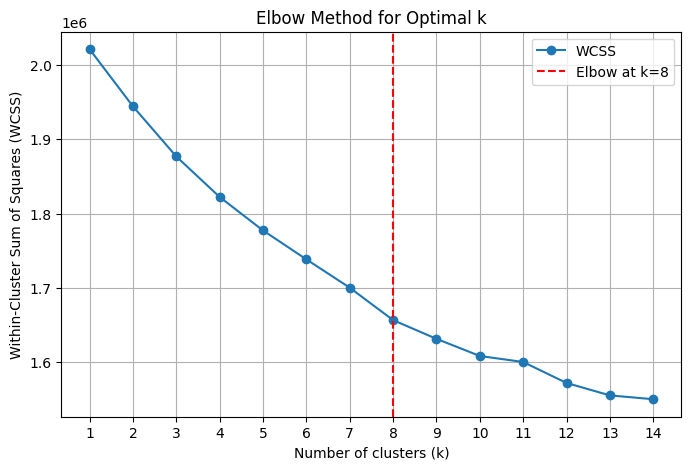

Optimal cut for ward linkage: 370.194


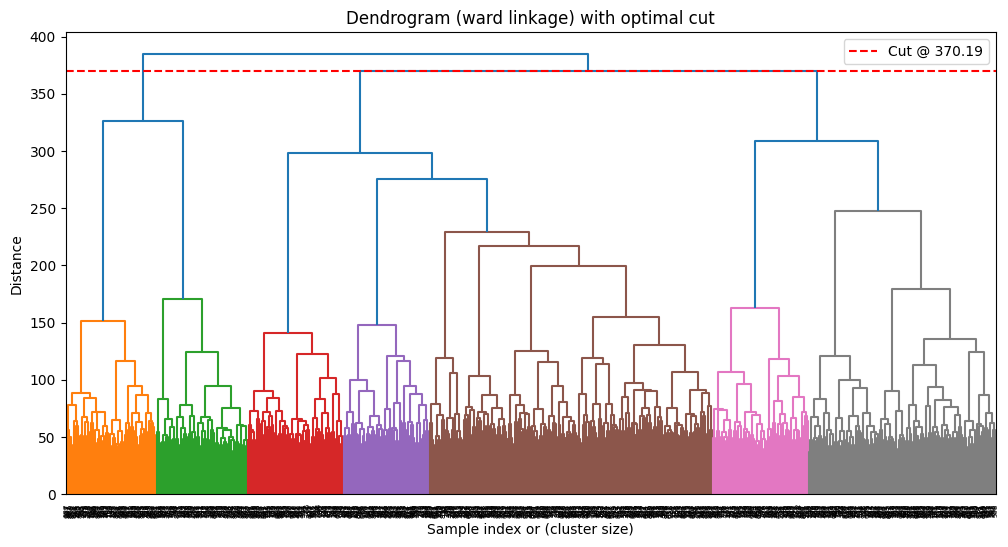

Optimal cut for average linkage: 28.740


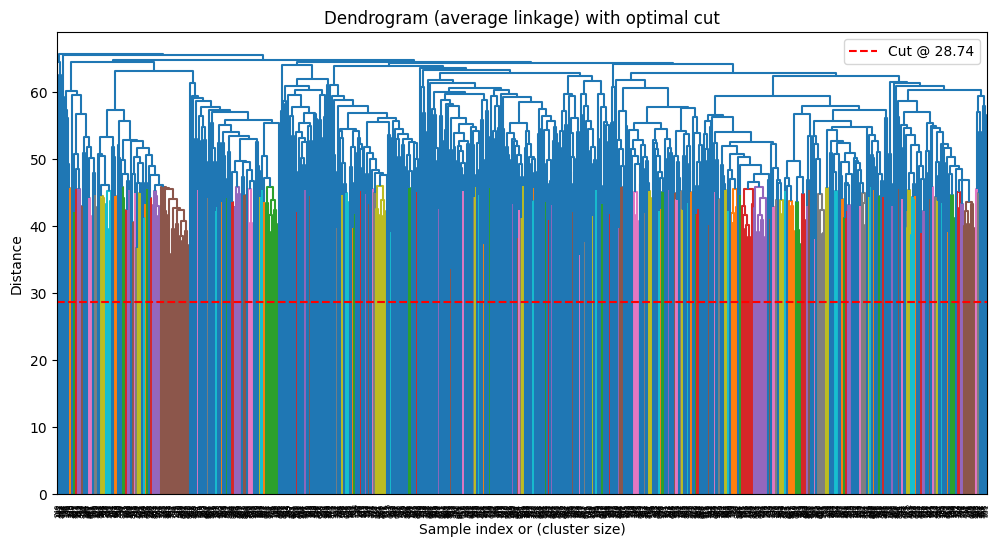

Optimal cut for complete linkage: 28.740


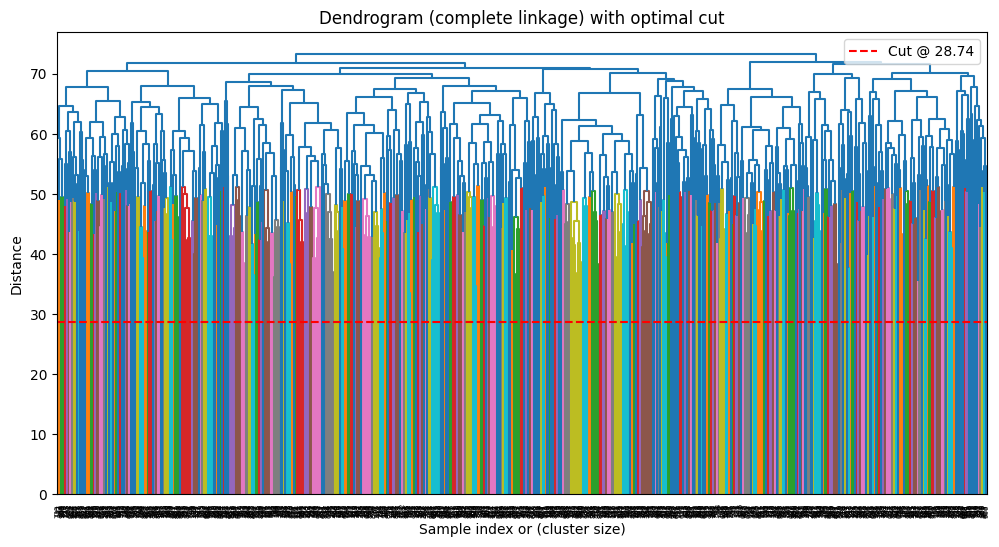

Optimal cut for single linkage: 28.740


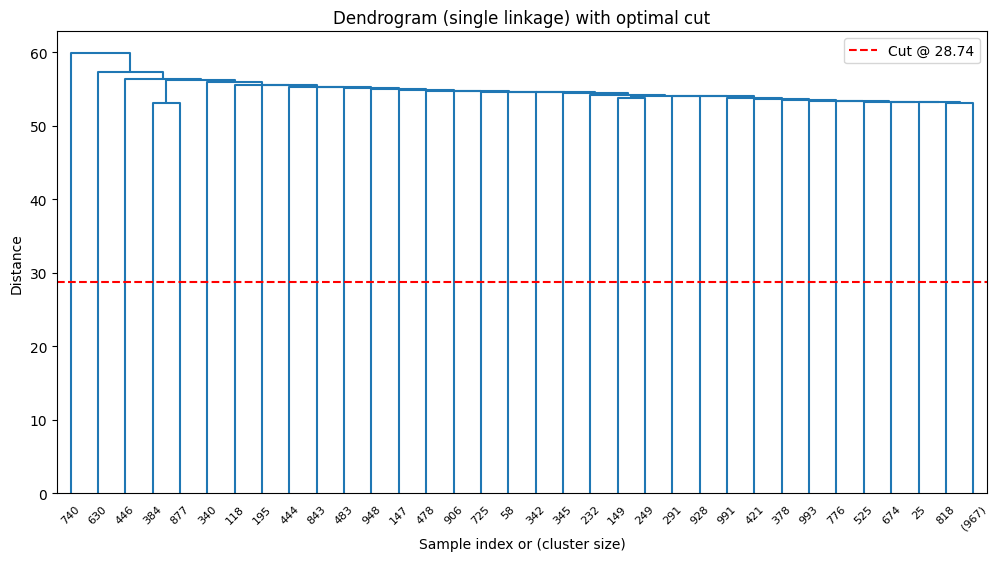


=== Cluster Evaluations ===
KMeans: 8 clusters, purity=0.775
DBSCAN: 0 clusters, purity=0.000
OPTICS: 1 clusters, purity=0.100
Hier-ward-optimal: 2 clusters, purity=0.200
Hier-average-optimal: 998 clusters, purity=1.000
Hier-complete-optimal: 998 clusters, purity=1.000
Hier-single-optimal: 998 clusters, purity=1.000


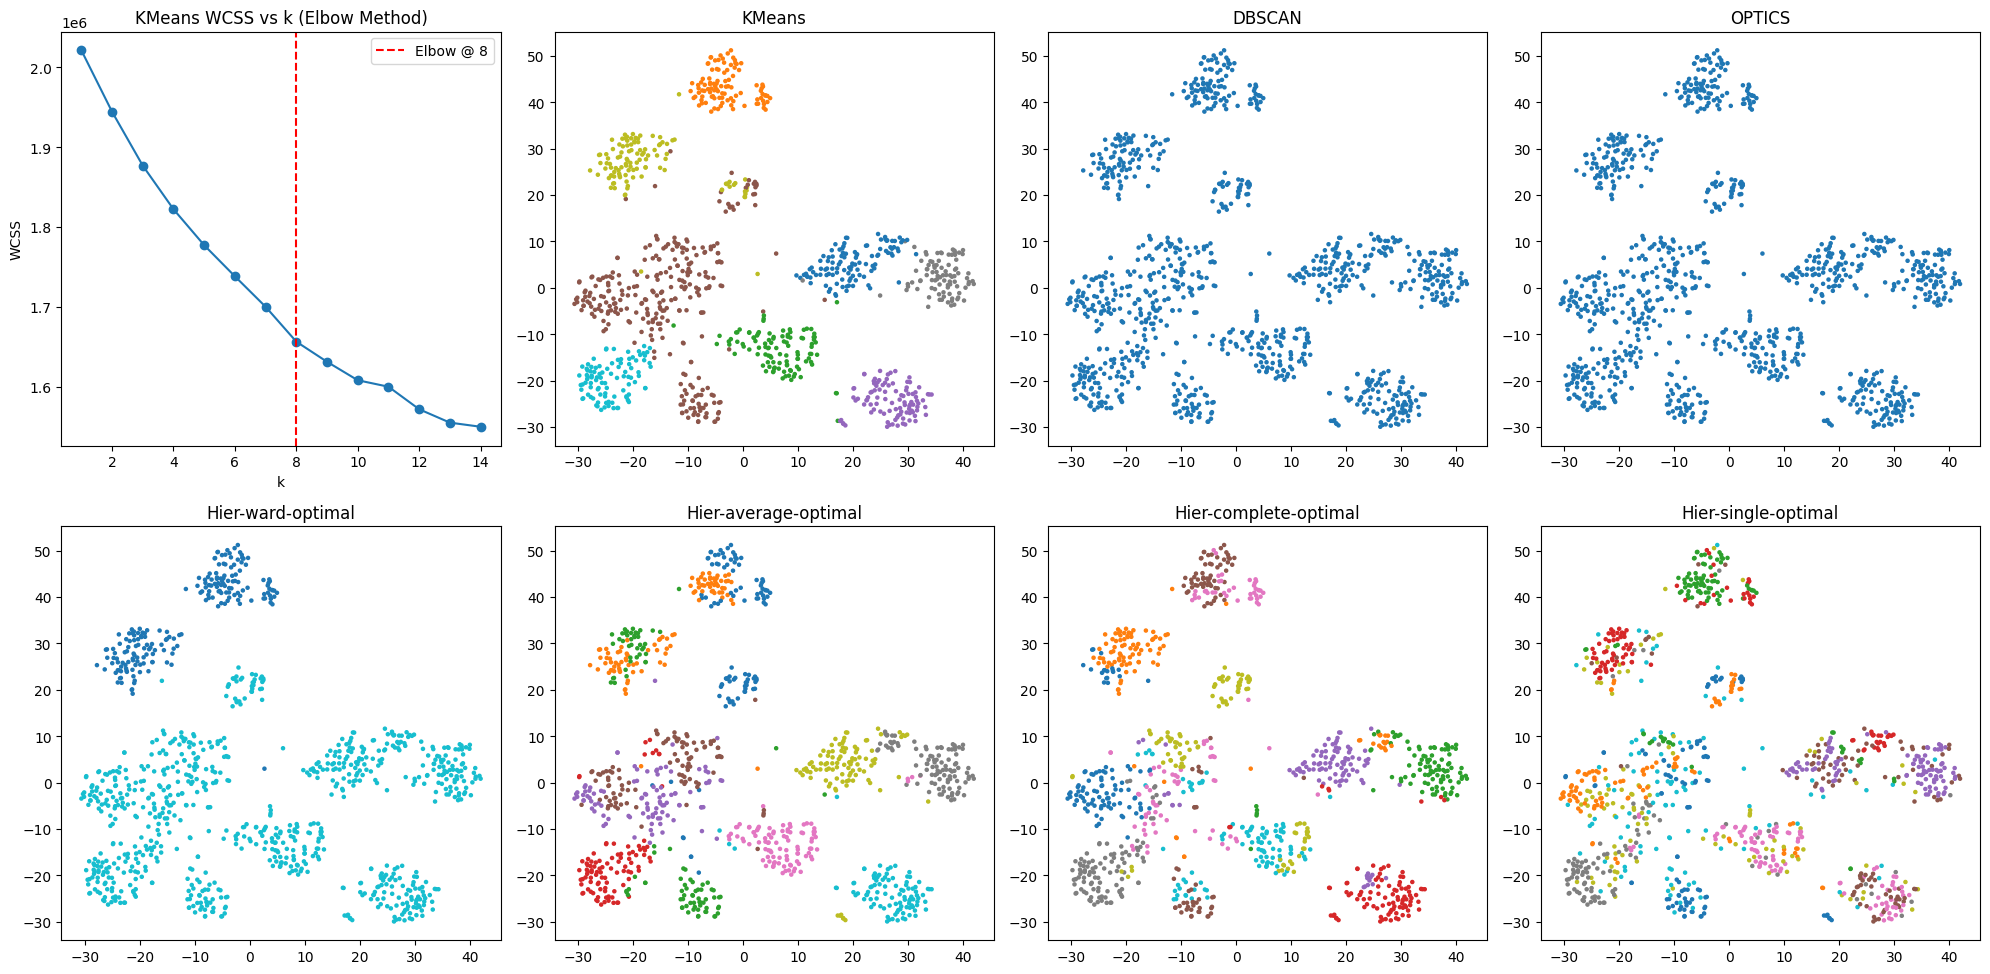

In [8]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, AutoModel
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from kneed import KneeLocator

# ==== 1. Load pretrained DINOv2 ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'facebook/dinov2-base'
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

# ==== 2. Balanced CIFAR-10 subset ====
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

full_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

N_PER_CLASS = 100
indices, class_counts = [], Counter()
for idx, (_, label) in enumerate(full_dataset):
    if class_counts[label] < N_PER_CLASS:
        indices.append(idx)
        class_counts[label] += 1
    if len(indices) == 10 * N_PER_CLASS:
        break

subset = torch.utils.data.Subset(full_dataset, indices)
dataloader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=False)

# ==== 3. Extract DINOv2 embeddings ====
all_embeddings, all_labels, original_images = [], [], []
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        outputs = model(pixel_values=images)
        cls_emb = outputs.last_hidden_state[:,0,:].cpu().numpy()
        all_embeddings.append(cls_emb)
        all_labels.append(labels.numpy())
        # Store unnormalized images for visualization
        original_images.append(images.cpu())

all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
original_images = torch.cat(original_images, dim=0)

print(f"Balanced subset: {len(all_labels)} images, embeddings shape {all_embeddings.shape}")

# ==== 4. Helper functions ====
def evaluate(labels, name, embeddings):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters

def cluster_purity(pred_labels, true_labels):
    clusters = set(pred_labels)
    total_correct = 0
    for c in clusters:
        if c == -1:
            continue
        mask = pred_labels == c
        if np.sum(mask) == 0:
            continue
        most_common = mode(true_labels[mask], keepdims=False).mode
        total_correct += np.sum(true_labels[mask] == most_common)
    return total_correct / len(true_labels)

# ==== 5. KMeans with Automatic Elbow Detection ====
wcss, K_range = [], range(1, 15)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(all_embeddings)
    wcss.append(km.inertia_)

knee = KneeLocator(K_range, wcss, curve='convex', direction='decreasing')
best_k = knee.knee
print(f"Automatically detected optimal K: {best_k}")

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', label='WCSS')
if best_k:
    plt.axvline(best_k, color='red', linestyle='--', label=f'Elbow at k={best_k}')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(K_range)
plt.legend()
plt.grid(True)
plt.show()

labels_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(all_embeddings)

# ==== 6. DBSCAN and OPTICS ====
labels_dbscan = DBSCAN(eps=1.0, min_samples=5).fit_predict(all_embeddings)
labels_optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05).fit_predict(all_embeddings)

# ==== 7. Hierarchical clustering with optimal dendrogram cut ====
linkages = ['ward', 'average', 'complete', 'single']
hierarchical_labels = {}
for link in linkages:
    try:
        Z = linkage(all_embeddings, method=link)
        distances = Z[:, 2]
        diffs = np.diff(distances)
        largest_gap_idx = np.argmax(diffs[:-1])
        optimal_cut = distances[largest_gap_idx + 1]
        print(f"Optimal cut for {link} linkage: {optimal_cut:.3f}")
        labels_hc = fcluster(Z, t=optimal_cut, criterion='distance')
        hierarchical_labels[f'{link}-optimal'] = labels_hc

        plt.figure(figsize=(12,6))
        dendrogram(Z, truncate_mode='level', p=30)
        plt.axhline(y=optimal_cut, color='red', linestyle='--', label=f'Cut @ {optimal_cut:.2f}')
        plt.title(f"Dendrogram ({link} linkage) with optimal cut")
        plt.xlabel("Sample index or (cluster size)")
        plt.ylabel("Distance")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Hierarchical {link} failed: {e}")

# ==== 8. Evaluate all ====
evaluations = {
    'KMeans': evaluate(labels_kmeans, 'KMeans', all_embeddings),
    'DBSCAN': evaluate(labels_dbscan, 'DBSCAN', all_embeddings),
    'OPTICS': evaluate(labels_optics, 'OPTICS', all_embeddings)
}
for key, labs in hierarchical_labels.items():
    evaluations[f'Hier-{key}'] = evaluate(labs, f'Hier-{key}', all_embeddings)

print("\n=== Cluster Evaluations ===")
for method, n_clusters in evaluations.items():
    purity = cluster_purity(
        labels_kmeans if method=='KMeans' else
        labels_dbscan if method=='DBSCAN' else
        labels_optics if method=='OPTICS' else
        hierarchical_labels[method.replace('Hier-','')],
        all_labels
    )
    print(f"{method}: {n_clusters} clusters, purity={purity:.3f}")

# ==== 9. Visualization via t-SNE ====
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(all_embeddings)

labels_viz = {
    'KMeans': labels_kmeans,
    'DBSCAN': labels_dbscan,
    'OPTICS': labels_optics
}
for key in list(hierarchical_labels.keys())[:5]:
    labels_viz[f'Hier-{key}'] = hierarchical_labels[key]

fig, axes = plt.subplots(2,4, figsize=(20,10))
axes = axes.flatten()
axes[0].plot(K_range, wcss, marker='o')
axes[0].axvline(best_k, color='red', linestyle='--', label=f'Elbow @ {best_k}')
axes[0].set_title("KMeans WCSS vs k (Elbow Method)")
axes[0].set_xlabel("k"); axes[0].set_ylabel("WCSS")
axes[0].legend()

for i,(method,labs) in enumerate(labels_viz.items(), start=1):
    axes[i].scatter(emb_2d[:,0], emb_2d[:,1], c=labs, s=5, cmap='tab10')
    axes[i].set_title(method)

plt.tight_layout()
plt.show()

# ==== 10. Function to show images of a selected cluster ====
def show_cluster_images(images, labels, cluster_id, num_images=16):
    """Display sample images from a specific cluster."""
    idxs = np.where(labels == cluster_id)[0]
    if len(idxs) == 0:
        print(f"No images found for cluster {cluster_id}.")
        return
    idxs = np.random.choice(idxs, size=min(num_images, len(idxs)), replace=False)
    cols = int(np.sqrt(len(idxs)))
    rows = int(np.ceil(len(idxs)/cols))

    plt.figure(figsize=(cols*2, rows*2))
    for i, idx in enumerate(idxs):
        img = images[idx].permute(1,2,0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # normalize for display
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id} Samples")
    plt.show()

# ==== Example usage ====
# To display images from cluster 0 of KMeans:


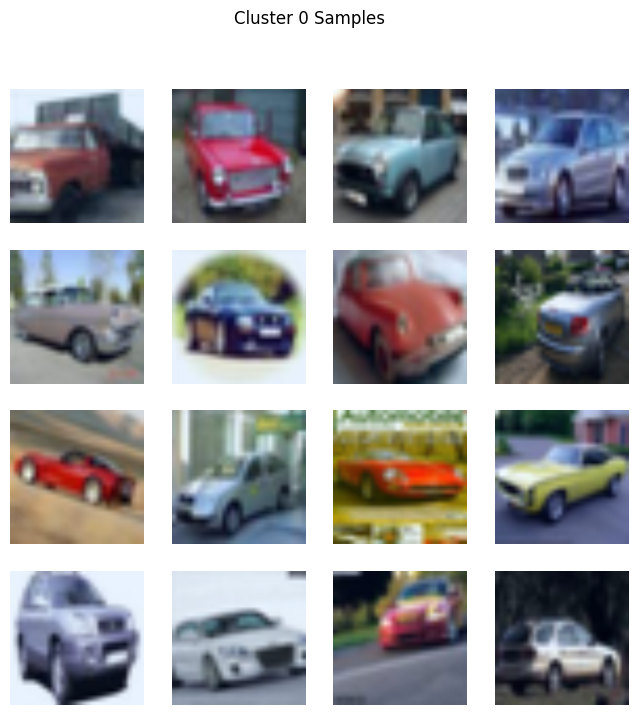

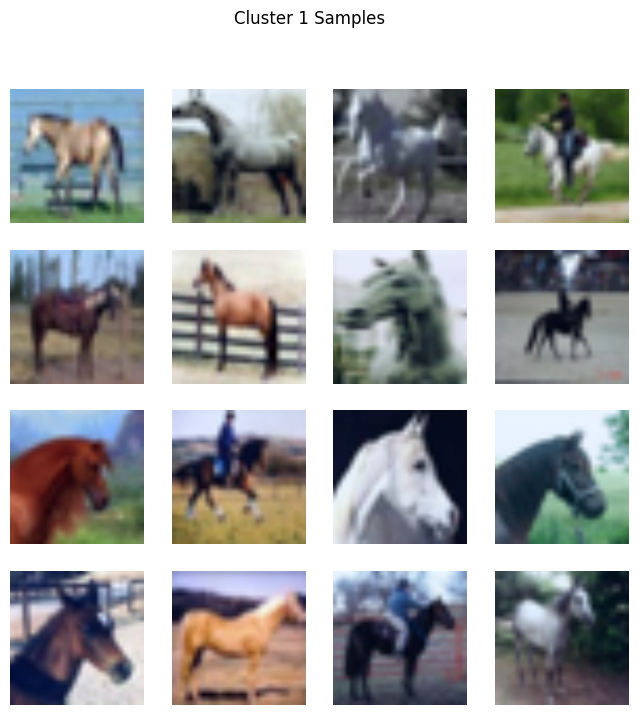

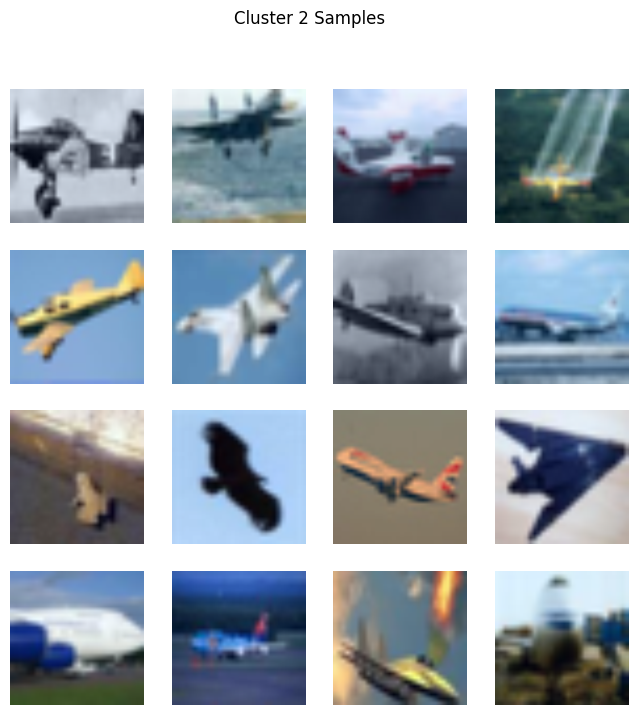

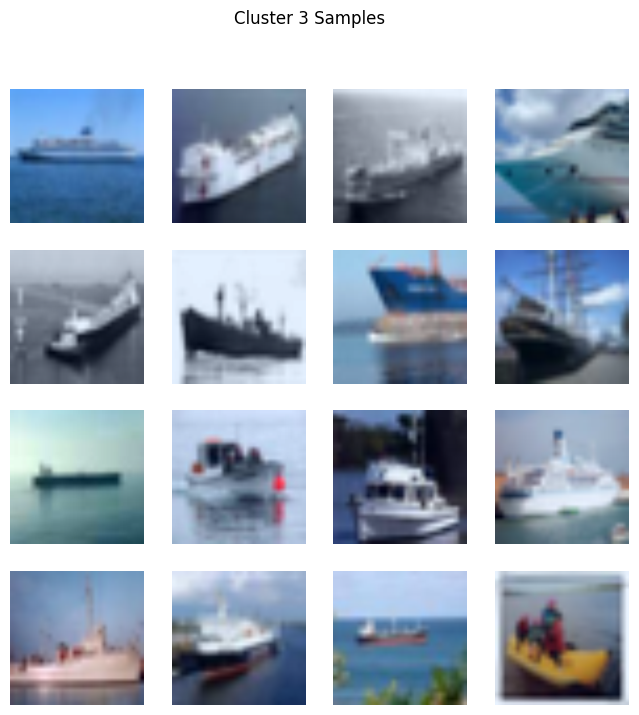

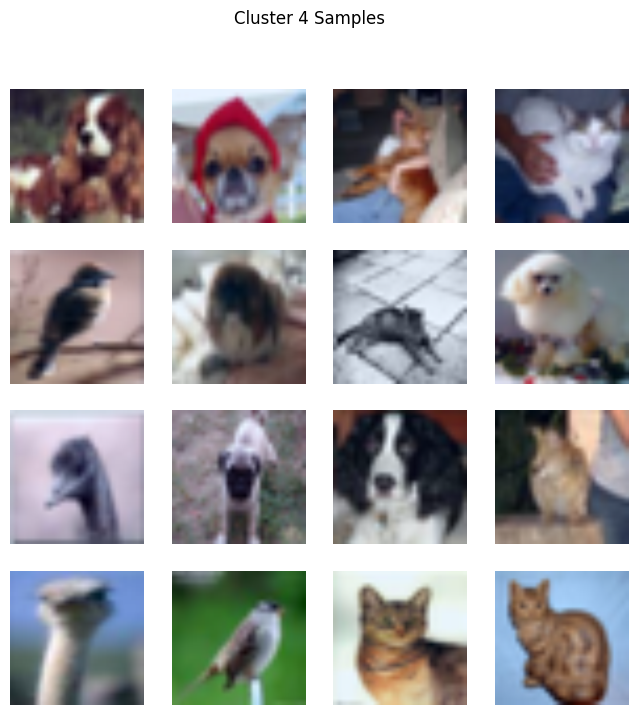

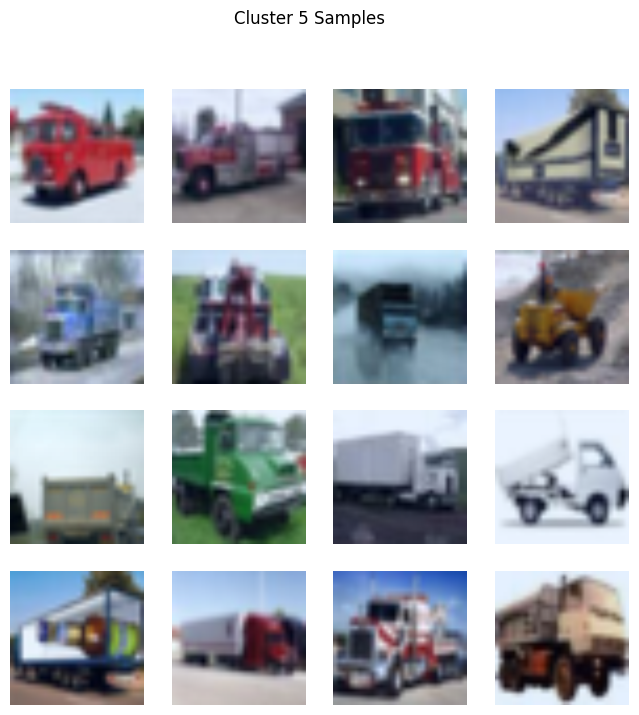

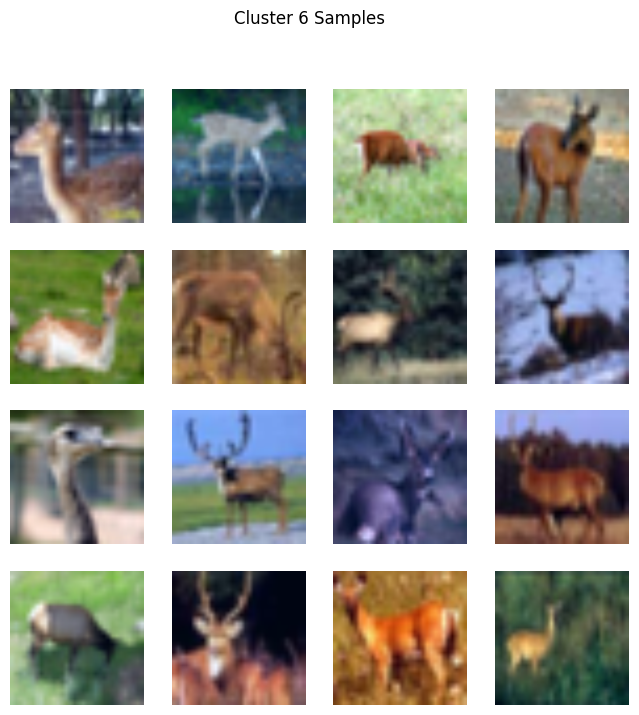

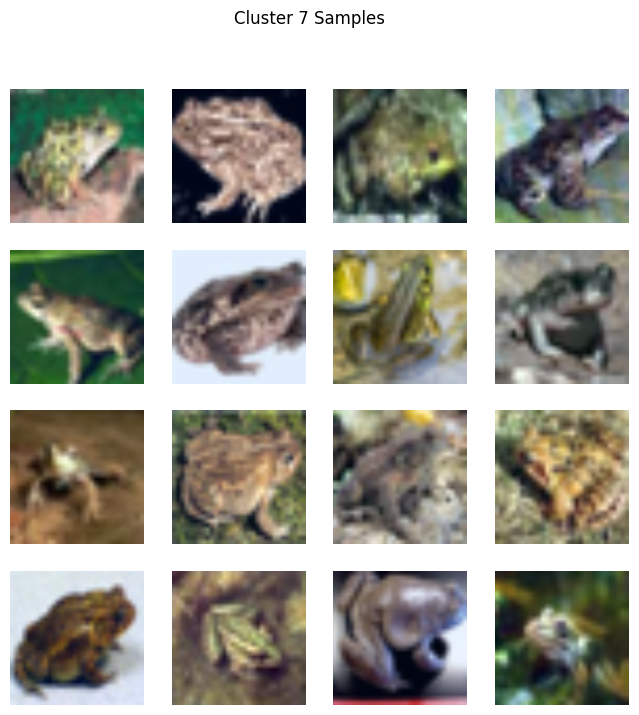

In [11]:
for i in range(0,best_k):
    show_cluster_images(original_images, labels_kmeans, cluster_id=i, num_images=16)


## FInal clustering to be used

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


Files already downloaded and verified
Balanced subset: 1000 images, embeddings shape (1000, 768)
Automatically detected optimal K: 8


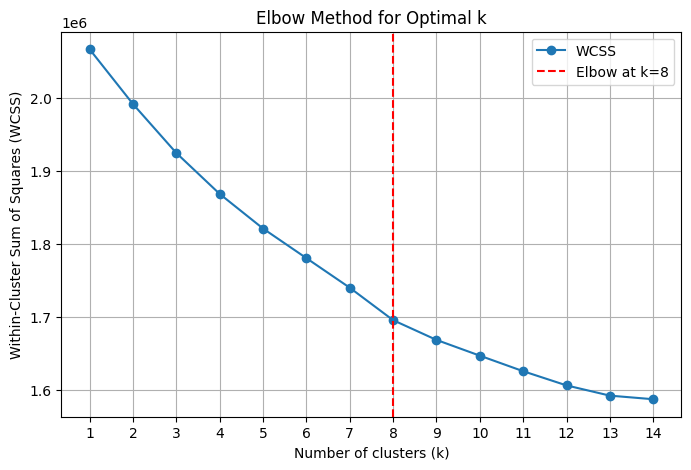

KMeans: 8 clusters, purity=0.766


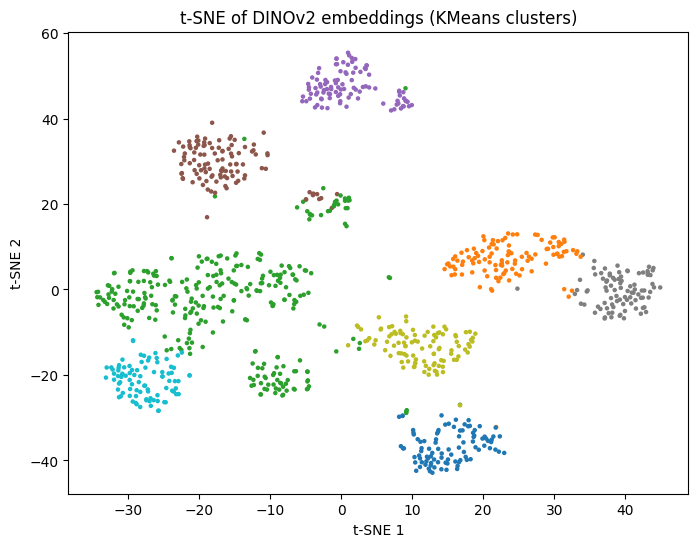

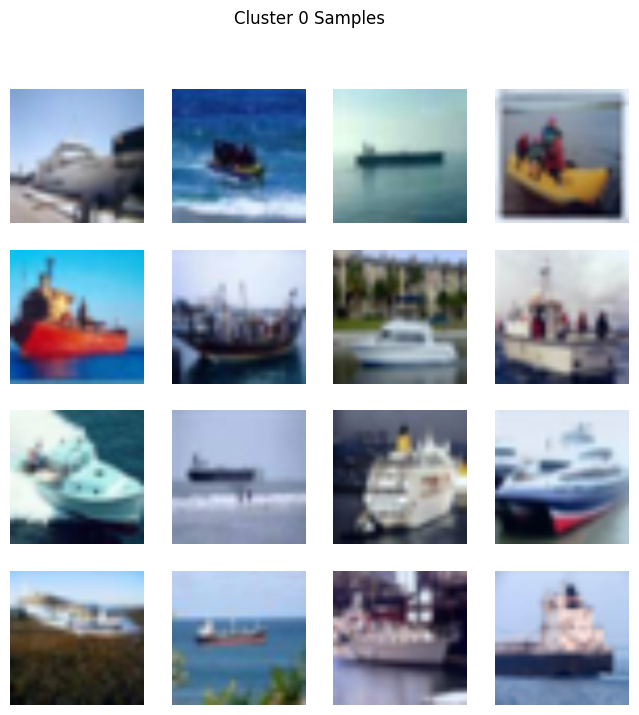

In [14]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, AutoModel
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import mode
from kneed import KneeLocator

# ==== 1. Load pretrained DINOv2 ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'facebook/dinov2-base'
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

# ==== 2. Balanced CIFAR-10 subset ====
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

full_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

N_PER_CLASS = 100
indices, class_counts = [], Counter()
for idx, (_, label) in enumerate(full_dataset):
    if class_counts[label] < N_PER_CLASS:
        indices.append(idx)
        class_counts[label] += 1
    if len(indices) == 10 * N_PER_CLASS:
        break

subset = torch.utils.data.Subset(full_dataset, indices)
dataloader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=False)

# ==== 3. Extract DINOv2 embeddings ====
all_embeddings, all_labels, original_images = [], [], []
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        outputs = model(pixel_values=images)
        cls_emb = outputs.last_hidden_state[:,0,:].cpu().numpy()
        all_embeddings.append(cls_emb)
        all_labels.append(labels.numpy())
        original_images.append(images.cpu())

all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
original_images = torch.cat(original_images, dim=0)

print(f"Balanced subset: {len(all_labels)} images, embeddings shape {all_embeddings.shape}")

# ==== 4. Helper functions ====
def cluster_purity(pred_labels, true_labels):
    clusters = set(pred_labels)
    total_correct = 0
    for c in clusters:
        if c == -1:
            continue
        mask = pred_labels == c
        if np.sum(mask) == 0:
            continue
        most_common = mode(true_labels[mask], keepdims=False).mode
        total_correct += np.sum(true_labels[mask] == most_common)
    return total_correct / len(true_labels)

# ==== 5. KMeans with Automatic Elbow Detection ====
wcss, K_range = [], range(1, 15)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(all_embeddings)
    wcss.append(km.inertia_)

knee = KneeLocator(K_range, wcss, curve='convex', direction='decreasing')
best_k = knee.knee
print(f"Automatically detected optimal K: {best_k}")

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', label='WCSS')
if best_k:
    plt.axvline(best_k, color='red', linestyle='--', label=f'Elbow at k={best_k}')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(K_range)
plt.legend()
plt.grid(True)
plt.show()

labels_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(all_embeddings)

purity = cluster_purity(labels_kmeans, all_labels)
print(f"KMeans: {best_k} clusters, purity={purity:.3f}")

# ==== 6. Visualization via t-SNE ====
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels_kmeans, s=5, cmap='tab10')
plt.title("t-SNE of DINOv2 embeddings (KMeans clusters)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

# ==== 7. Function to show images of a selected cluster ====
def show_cluster_images(images, labels, cluster_id, num_images=16):
    """Display sample images from a specific cluster."""
    idxs = np.where(labels == cluster_id)[0]
    if len(idxs) == 0:
        print(f"No images found for cluster {cluster_id}.")
        return
    idxs = np.random.choice(idxs, size=min(num_images, len(idxs)), replace=False)
    cols = int(np.sqrt(len(idxs)))
    rows = int(np.ceil(len(idxs)/cols))

    plt.figure(figsize=(cols*2, rows*2))
    for i, idx in enumerate(idxs):
        img = images[idx].permute(1,2,0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id} Samples")
    plt.show()

# ==== Example usage ====
show_cluster_images(original_images, labels_kmeans, cluster_id=0)


Query image assigned to cluster 2 (distance=41.684)


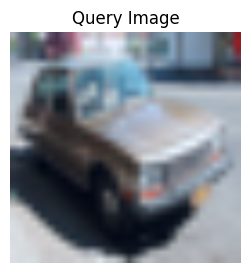

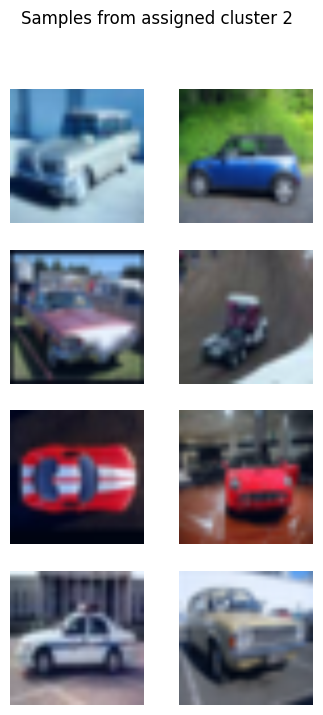

Query image assigned to cluster 5 (distance=47.252)


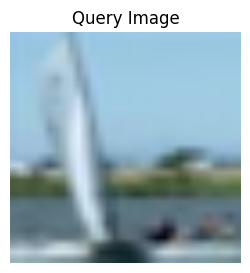

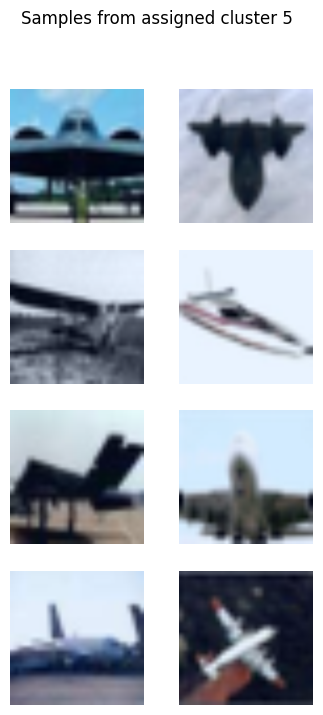

Query image assigned to cluster 6 (distance=38.427)


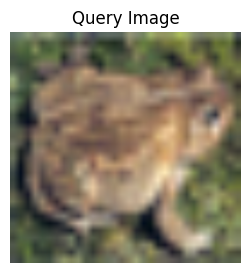

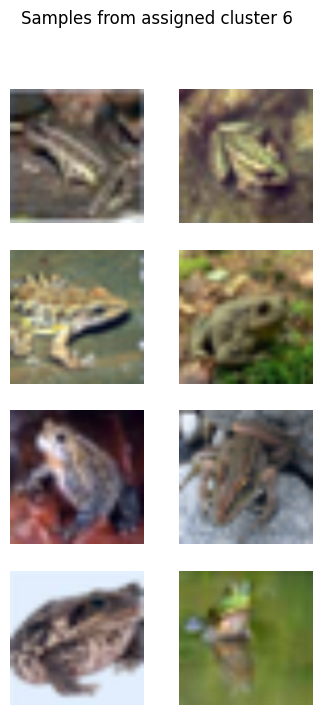

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# ==== 8. Inference function using KMeans centroids ====
def assign_cluster(image, processor, model, kmeans_model, device):
    """
    Assign a new image to the closest KMeans cluster.
    """
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
    ])
    if not isinstance(image, torch.Tensor):
        image = transform(image).unsqueeze(0)  # add batch dim
    else:
        image = image.unsqueeze(0)

    image = image.to(device)

    # Get embedding
    with torch.no_grad():
        outputs = model(pixel_values=image)
        emb = outputs.last_hidden_state[:,0,:].cpu().numpy()  # shape (1, dim)

    # Find closest centroid
    centroids = kmeans_model.cluster_centers_
    distances = np.linalg.norm(centroids - emb, axis=1)
    cluster_id = np.argmin(distances)
    return cluster_id, distances[cluster_id]

# ==== 9. Display query image + cluster samples ====
def show_query_and_cluster(query_idx, original_images, labels, kmeans_model, processor, model, device, num_samples=8):
    query_image = original_images[query_idx]
    cluster_id, dist = assign_cluster(query_image, processor, model, kmeans_model, device)
    print(f"Query image assigned to cluster {cluster_id} (distance={dist:.3f})")

    # Show query image
    plt.figure(figsize=(3,3))
    img = query_image.permute(1,2,0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.axis('off')
    plt.title("Query Image")
    plt.show()

    # Show samples from the assigned cluster
    idxs = np.where(labels_kmeans == cluster_id)[0]
    idxs = np.random.choice(idxs, size=min(num_samples, len(idxs)), replace=False)

    cols = int(np.sqrt(len(idxs)))
    rows = int(np.ceil(len(idxs)/cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i, idx in enumerate(idxs):
        img = original_images[idx].permute(1,2,0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Samples from assigned cluster {cluster_id}")
    plt.show()

# ==== Example usage ====
# Randomly select a few CIFAR images from your subset
for query_idx in np.random.choice(len(original_images), 3, replace=False):
    show_query_and_cluster(query_idx, original_images, all_labels, 
                           kmeans_model=KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(all_embeddings), 
                           processor=processor, model=model, device=device, num_samples=8)

